In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yasa
import seaborn as sns
import ghibtools as gh
import mne
import glob
import time
import datetime
import yasa
from scipy import signal
import json
from params import *

In [57]:
subject = 'S1'

In [58]:
data = xr.open_dataarray(f'../preproc/{subject}_reref.nc') # load preprocessed data (lazy load)

In [59]:
def complex_mw(time, n_cycles , freq, a= 1, m = 0): 
    """
    time : time vector of the wavelet
    n_cycles : number of cycles in the wavelet
    freq : frequency of the wavelet
    a : amplitude of the wavelet
    m : x center of the wavelet
    """
    s = n_cycles / (2 * np.pi * freq)
    GaussWin = a * np.exp( -(time - m)** 2 / (2 * s**2)) # real gaussian window
    complex_sinewave = np.exp(1j * 2 *np.pi * freq * time) # complex sinusoidal signal
    cmw = GaussWin * complex_sinewave
    return cmw

In [60]:
tmw = np.arange(-2,2,1/srate)
mw = complex_mw(tmw, n_cycles = 30, freq= 20)

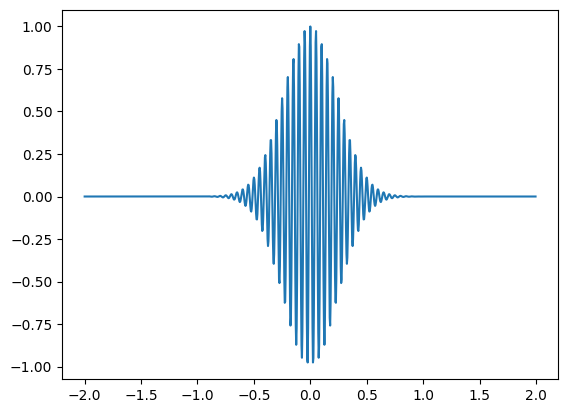

In [61]:
fig, ax = plt.subplots()
ax.plot(tmw, np.real(mw))

In [170]:
def morlet_family(srate, f_start, f_stop, n_step, n_cycles, show = False):
    tmw = np.arange(-20,20,1/srate)
    freqs = np.linspace(f_start,f_stop,n_step) 
    mw_family = np.zeros((freqs.size, tmw.size), dtype = 'complex')
    for i, fi in enumerate(freqs):
        mw_family[i,:] = complex_mw(tmw, n_cycles = n_cycles, freq = fi)
    if show:
        fig, ax = plt.subplots()
        im = ax.pcolormesh(tmw, freqs, np.real(mw_family))
        ax.set_ylabel('Freq [Hz]')
        ax.set_xlabel('Time')
        fig.colorbar(im)
        plt.show()
    return freqs, mw_family

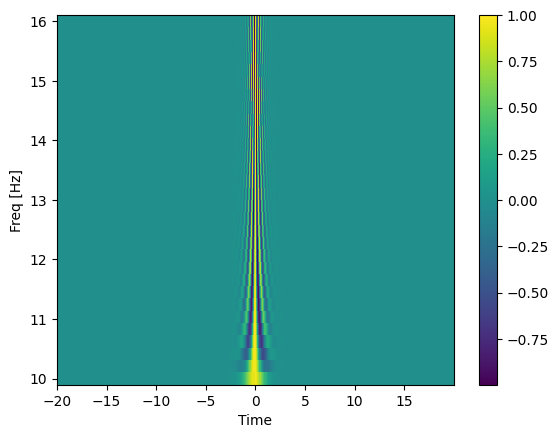

In [171]:
freq , family = morlet_family(srate, f_start = 10, f_stop = 16, n_step = 30, n_cycles = 50, show = True)

In [103]:
t_target = 10000
delta = 15
t_start = t_target - delta
t_stop = t_target + delta
sig = data.sel(chan = 'Fp2', time = slice(t_start,t_stop)).data

In [136]:
def compute_tf(sig, srate, f_start, f_stop, n_step, n_cycles):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    for i in range(family.shape[0]):
        mw = family[i,:]
        tf[i,:] = signal.fftconvolve(sig, mw, mode = 'same')
    return freqs , np.abs(tf)

In [177]:
def compute_tf_fast(sig, srate, f_start, f_stop, n_step, n_cycles, feature = 'module', exponent = 1):
    freqs, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles)
    tf = np.zeros((family.shape[0], sig.size), dtype = 'complex')
    sigs = np.tile(sig, (n_step,1))
    tf = signal.fftconvolve(sigs, family, mode = 'same', axes = 1)
    if feature == 'module':
        return freqs , np.abs(tf) ** exponent
    elif feature == 'real':
        return freqs , np.real(tf) ** exponent

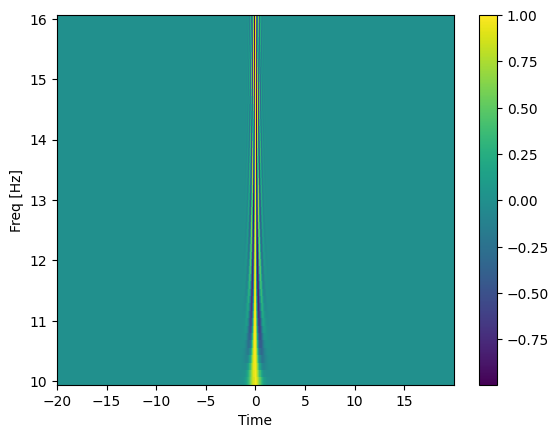

In [172]:
f_start = 10
f_stop = 16
n_step = 50
n_cycles = 30
freq, family = morlet_family(srate, f_start = f_start, f_stop = f_stop, n_step = n_step, n_cycles = n_cycles, show = True)
f_fast = np.linspace(f_start,f_stop,n_step) 
t = np.arange(0, sig.size/srate, 1 / srate)

tf_fast = np.zeros((family.shape[0], sig.size), dtype = 'complex')
for i in range(family.shape[0]):
    mw = family[i,:]
    tf_fast[i,:] = signal.fftconvolve(sig, mw, mode = 'same', axes = 0)

0.04819604498334229
srate down 51.2
0.008898837957531214
ratio duration 5.415993100824281


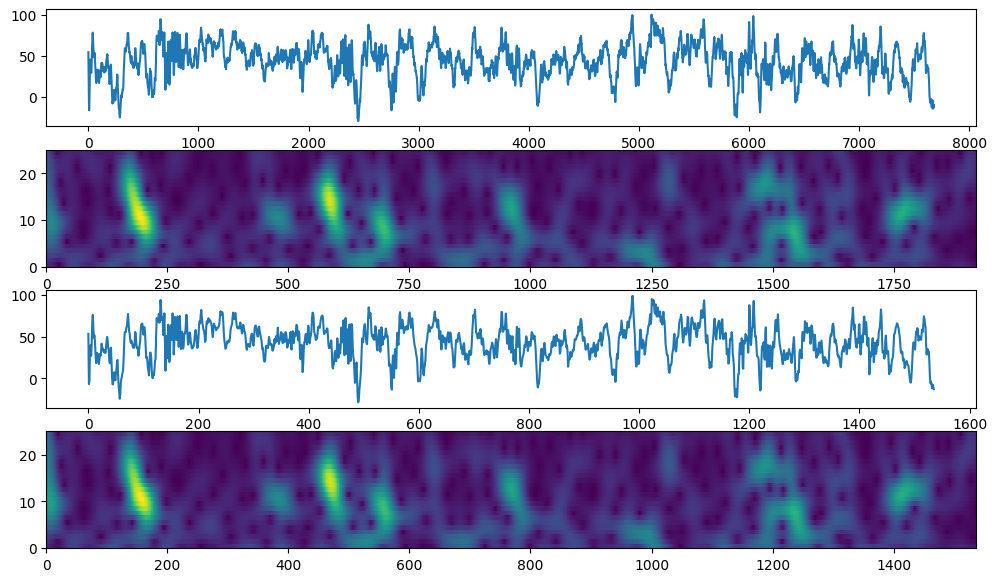

In [173]:
fig, axs = plt.subplots(nrows = 4, figsize = (12,7))
ax = axs[0]
ax.plot(sig)
ax = axs[1]
t1 = time.perf_counter()
f, tf = compute_tf_fast(sig, srate, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 20)
t2 = time.perf_counter()
duration_full = t2 - t1
print(duration_full)
ax.pcolormesh(signal.decimate(tf, q=4))

factor = 5
srate_down = srate / factor
sig_decimate = signal.decimate(sig, q=factor)
ax = axs[2]
ax.plot(sig_decimate)
ax = axs[3]
t1 = time.perf_counter()
f, tf = compute_tf_fast(sig_decimate, srate_down, f_start=10 , f_stop = 16 , n_step = 25, n_cycles = 20)
print('srate down', srate_down)
t2 = time.perf_counter()
duration_down = t2 - t1
print(duration_down)
ratio_duration = duration_full / duration_down
print('ratio duration', ratio_duration)
ax.pcolormesh(tf)


In [260]:
t_target = 10060
delta = 15
t_start = t_target - delta
t_stop = t_target + delta
ind_start = int(t_start * srate)
ind_stop = int(t_stop * srate)
# sig = data.sel(chan = 'Fp1', time = slice(t_start,t_stop)).data
sig = data[0,ind_start:ind_stop].data

marker_t = 4434.9

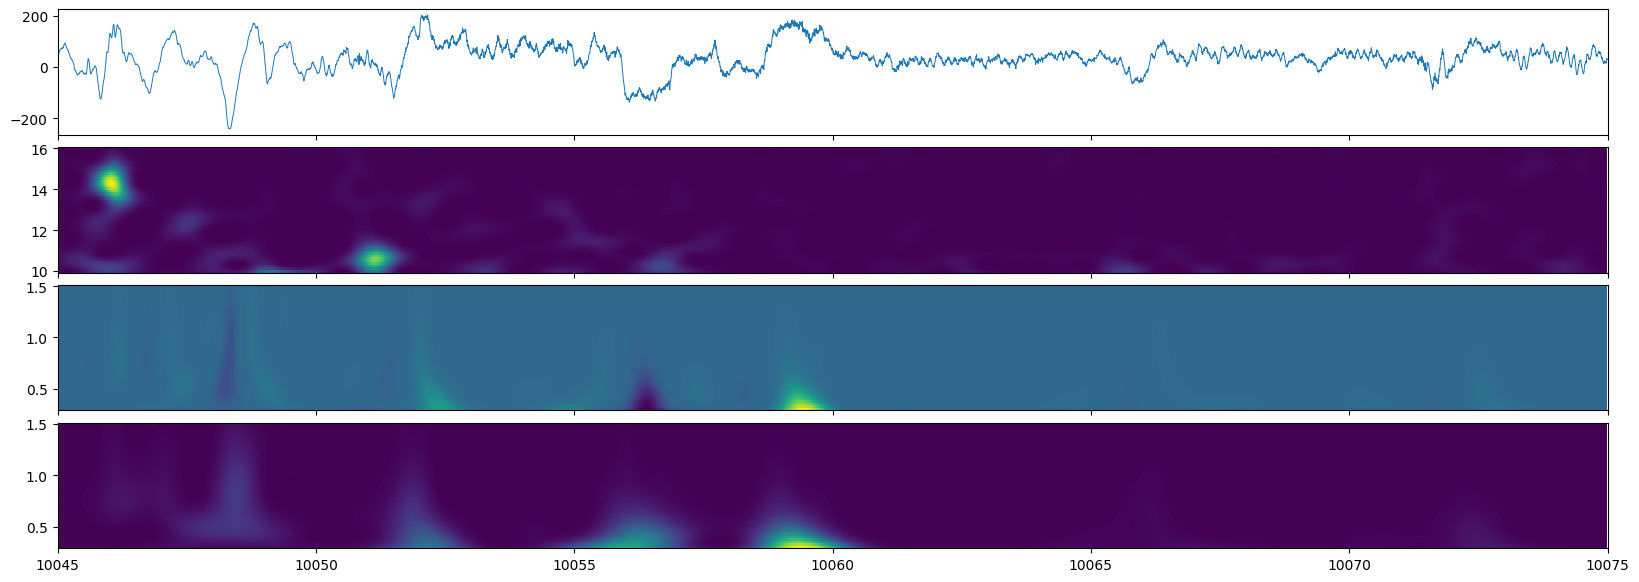

In [261]:
fig, axs = plt.subplots(nrows = 4, figsize = (20,7), sharex = True)
fig.subplots_adjust(hspace = 0.1)

t = np.arange(t_start, t_stop, 1 /srate)

ax = axs[0]
ax.plot(t,sig, lw = 0.7)
ax.set_xlim(t_start, t_stop)
ax.axvline(x = marker_t, color = 'r')

ax = axs[1]
f, tf = compute_tf_fast(sig, srate, f_start=10 , f_stop = 16 , n_step = 50, n_cycles = 25, feature = 'module', exponent = 3)
ax.pcolormesh(t, f , tf)

ax = axs[2]
f, tf = compute_tf_fast(sig, srate, f_start=0.3 , f_stop = 1.5 , n_step = 50, n_cycles = 2, feature = 'real', exponent = 3)
ax.pcolormesh(t,f,tf)

ax = axs[3]
f, tf = compute_tf_fast(sig, srate, f_start=0.3 , f_stop = 1.5 , n_step = 50, n_cycles = 2, feature = 'module', exponent = 3)
ax.pcolormesh(t,f,tf)

In [253]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_reref_yasa.xlsx', index_col = 0)

In [78]:
spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W


In [35]:
def spindle_speed(freq, threshold):
    if freq <= threshold:
        return 'SS'
    elif freq > threshold:
        return 'FS'

In [36]:
sp_speeds = []
for i, row in spindles.iterrows():
    sp_speeds.append(spindle_speed(freq=row['Frequency'], threshold=spindles_freq_threshold[subject]))

In [41]:
spindles['Spindle_Speed'] = sp_speeds

In [42]:
spindles

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel,Stage_Letter,Spindle_Speed
0,15.160156,15.910156,16.777344,1.617188,76.690796,14.541233,1.512471,0.058145,12.064345,16,0.462651,0,Fp2,0,W,SS
1,22.515625,23.867188,24.289062,1.773438,77.093320,15.279712,1.575529,0.067565,11.343477,19,0.760440,0,Fp2,0,W,SS
2,54.046875,54.343750,54.792969,0.746094,52.904826,11.853407,1.707664,0.080165,11.542135,9,0.395833,0,Fp2,0,W,SS
3,65.800781,66.808594,67.613281,1.812500,150.039012,24.185366,1.568414,0.036664,12.304631,18,0.554839,0,Fp2,0,W,SS
4,68.812500,69.324219,69.476562,0.664062,61.455435,14.984043,1.920190,0.090785,11.094523,7,0.766082,0,Fp2,0,W,SS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23909,31528.738281,31529.136719,31530.035156,1.296875,94.976470,20.093595,2.470019,0.163564,10.587642,14,0.306306,0,O2,10,W,SS
23910,31577.636719,31579.066406,31579.316406,1.679688,107.811221,21.689694,2.355104,0.125338,10.808945,17,0.849188,0,O2,10,W,SS
23911,31580.867188,31581.484375,31582.281250,1.414062,110.132798,21.056076,2.295392,0.127765,10.974576,13,0.435262,0,O2,10,W,SS
23912,31606.960938,31607.433594,31607.636719,0.675781,49.719578,11.367692,2.265527,0.190931,10.706575,8,0.695402,0,O2,10,W,SS


In [55]:
pd.crosstab(spindles['Spindle_Speed'], spindles['Channel'])

Channel,C3,C4,Cz,Fp1,Fp2,Fz,O1,O2,Pz,T3,T4
Spindle_Speed,,,,,,,,,,,
FS,983,958,1313,186,193,566,191,192,1120,424,345
SS,1539,1723,1156,2446,2420,2162,487,501,328,2399,2282
